# Fourier approximation of closed contours
Due to a conversation with my girlfriend about [John von Neumann's elephant](https://en.wikipedia.org/wiki/Von_Neumann%27s_elephant), I wanted to test how the Fourier series approximation of contours of animals looks like. A quick online search revealed paper [1] where Fourier series approximations of so-called chain codes were computed - a chain code is a piecewise linear curve representing a boundary in a pixelated image here, so just what we need. This notebook, which is the product of a long weekend spent sick in bed, 
- reads in an image and extracts the boundary from the binary object,
- performs depth-first search to extract the chain code from the boundary (this implicitly takes care of small defects in the boundary computed from the binary image, but requires that the object's boundary is a closed curve of adjacent pixels, i.e., horizontally, vertically and diagonally),
- computes the Fourier series approximation for a given accuracy from the chain code and
- plots the true boundary and its Fourier series approximation.

[1]: Kuhl & Giardina, 1982. 
    Elliptic Fourier Features of a Closed Contour.
    Computer Graphics and Image Processing 18, 236-258

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import sys
sys.setrecursionlimit(20000) # necessary to do a full dfs around the rhino

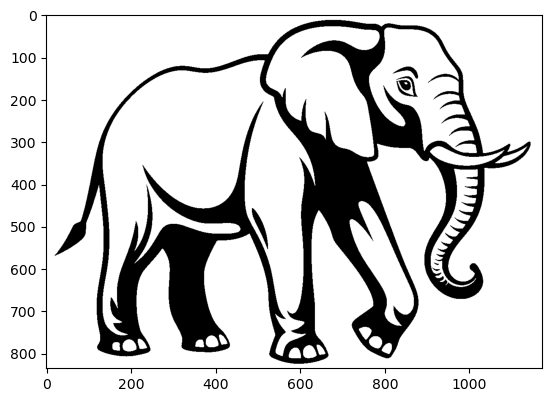

In [19]:
## Read in binary image - if color/grayscale convert to useful binary of object first
im = io.imread('test_img/elephant.png', as_gray=True)
# convert to binary
b = np.zeros(im.shape)
b[im>0.5] = 1
plt.imshow(b,cmap='gray');

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import sys
sys.setrecursionlimit(20000) # necessary to do a full dfs around the rhino

1


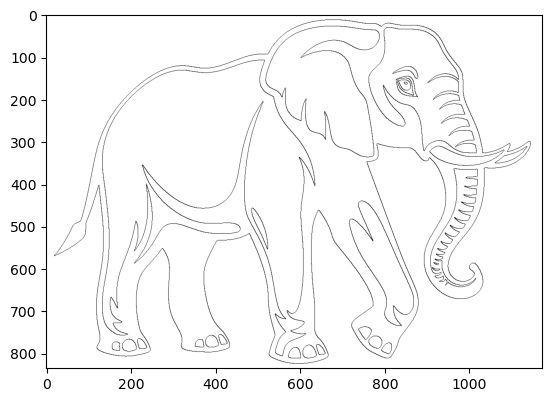

In [39]:
# Extract boundary of the object by taking image gradient 
# (and hoping that it produces a traversible closed chain of pixels)
def image_gradient(im):
    p = np.zeros((2,)+im.shape)
    p[0,0:-1,:] = im[1:,:]-im[0:-1,:]
    p[1,:,0:-1] = im[:,1:]-im[:,0:-1]
    return p

g = image_gradient(b)
h = (g[0,...]**2+g[1,...]**2>0).astype(int)
plt.imshow(h,cmap='gray_r',vmin=0,vmax=1)
# starting pixel for elephant
I_start, J_start = [545],[38]
print(h[I_start[0],J_start[0]])
# starting pixels for rhino2.jpg (one for outer, one for gap between legs)
# I_start,J_start = [650,2000], [704,1558]

## Depth-first search
Extract the chain code from the binary image where boundary pixels have value 1, all other pixels value 0.

In [6]:
inc = [(-1,-1),(-1,1),(1,-1),(1,1),(0,1),(-1,0),(0,-1),(1,0)]
cc_dict = {(0,1):0, (-1,1):1, (-1,0):2, (-1,-1):3, (0,-1):4, (1,-1):5, (1,0):6, (1,1):7}

def extract_cc(im,i1,i2):
    """
    Extract the chain code from the image im which has 
    value 1 on the boundary and 0 otherwise.
    For this to work, boundary has to be closed.
    Implemented using dfs, giving output once arrived 
    at starting pixel again; counter makes 
    sure the algorithm does not stop on first step.
    """
    d = np.zeros_like(im)
    return dfs(im,d,i1,i2,0,i1,i2,[]);

def dfs(im,d,i1,i2,counter,e1,e2,C):
    d[i1,i2] = 1
    for i in inc:
        j1,j2 = i1+i[0],i2+i[1]
        if j1<im.shape[0] and j2<im.shape[1] and im[j1,j2] == 1:
            if j1==e1 and j2==e2 and counter>1:
                return C+[cc_dict[i]]
            if d[j1,j2] == 0:
                r = dfs(im,d,j1,j2,counter+1,e1,e2,C+[cc_dict[i]])
                if r is not None:
                    return r

Small test image, to make sure this works:

[1, 3, 0, 7, 7, 5, 4, 3]


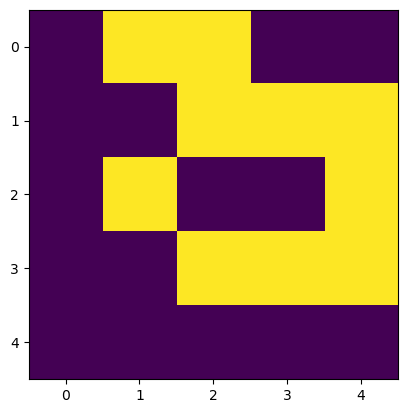

In [7]:
A = np.zeros((5,5))
A[1,2:]=1
A[3,2:]=1
A[2,1]=1
A[2,4]=1
A[0,1:3]=1
plt.imshow(A)
cc = extract_cc(A,2,1)
print(cc)

## Define a function that recomputes the x,y positions from the chain code

In [8]:
def true_contour(cc):
    """
    method that computes the x,y positions of true contour from chain code cc
    """
    K = cc.shape[0]
    x,y = np.zeros((K+1,)),np.zeros((K+1,))
    for i in range(K):
        c = cc[i]
        dx = 1 if c in [7,0,1] else (-1 if c in [3,4,5] else 0)
        dy = 1 if c in [1,2,3] else (-1 if c in [5,6,7] else 0)
        x[i+1] = x[i] + dx
        y[i+1] = y[i] + dy
    return x,y


## Function computing Fourier series coefficients from the chain code

In [9]:
def fourier_contour(cc,n_fc,n_eval=200):
    """
    Method from paper [1]: Compute a Fourier approximation of the 
    closed, piecewise linear curve given by the chain code cc. 
    Approximation is computed up to n_fc terms (plus constant term).
    
    [1]: Kuhl & Giardina, 1982. 
    Elliptic Fourier Features of a Closed Contour.
    Computer Graphics and Image Processing 18, 236-258
    """
    cc = np.reshape(cc,(-1,1))
    K = cc.shape[0]
    dx = np.sign(6-cc)*np.sign(2-cc)
    dy = np.sign(4-cc)*np.sign(cc)
    dt = 1+(np.sqrt(2)-1)/2*(1-(-1)**cc)
    t = np.zeros((K+1,1))
    for i in range(K):
        t[i+1,0] = t[i,0]+dt[i,0]
    T = t[-1,0]

    xi,delta = np.zeros((K,1)), np.zeros((K,1))
    for i in range(1,K):
        xi[i,0] = np.sum(dx[:i,0])-dx[i,0]/dt[i,0]*np.sum(dt[:i,0])
        delta[i,0] = np.sum(dy[:i,0])-dy[i,0]/dt[i,0]*np.sum(dt[:i,0])

    nn = np.arange(1,n_fc+1)[np.newaxis,:]
    a = T/(2*nn**2*np.pi**2)*np.sum(dx/dt*(np.cos(2*nn*np.pi*t[1:]/T)-np.cos(2*nn*np.pi*t[:-1]/T)),axis=0)
    b = T/(2*nn**2*np.pi**2)*np.sum(dx/dt*(np.sin(2*nn*np.pi*t[1:]/T)-np.sin(2*nn*np.pi*t[:-1]/T)),axis=0)
    c = T/(2*nn**2*np.pi**2)*np.sum(dy/dt*(np.cos(2*nn*np.pi*t[1:]/T)-np.cos(2*nn*np.pi*t[:-1]/T)),axis=0)
    d = T/(2*nn**2*np.pi**2)*np.sum(dy/dt*(np.sin(2*nn*np.pi*t[1:]/T)-np.sin(2*nn*np.pi*t[:-1]/T)),axis=0)
    a0 = 1/T*np.sum(dx/(2*dt)*(t[1:]**2-t[:-1]**2) + xi*dt)
    c0 = 1/T*np.sum(dy/(2*dt)*(t[1:]**2-t[:-1]**2) + delta*dt)

    tt = np.linspace(0,T,num=n_eval,endpoint=True)[:,np.newaxis]
    xx = a0 + np.sum(a*np.cos(2*nn*np.pi*tt/T) + b*np.sin(2*nn*np.pi*tt/T),axis=1)
    yy = c0 + np.sum(c*np.cos(2*nn*np.pi*tt/T) + d*np.sin(2*nn*np.pi*tt/T),axis=1)

    return xx,yy

Small chain code closed curve to test the Fourier approximation

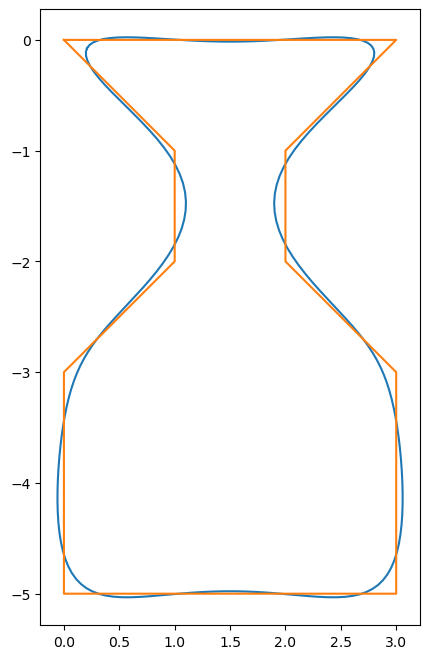

In [14]:
# two test chain codes of closed contours
# cc = np.array([int(d) for d in '00000656764433322'])
cc = np.array([int(d) for d in '0005676644422123'])
x_true,y_true = true_contour(cc)
N_fc = 8    # number of fourier coefficients
x_four,y_four = fourier_contour(cc,N_fc)

fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(x_four,y_four)
ax.plot(x_true,y_true)
ax.set_aspect(1)

## Compute the chain codes
Two chain codes in case of the rhino - one for the outer contour, one for the gap between the front legs

In [40]:
cc = []
for k,(i_start,j_start) in enumerate(zip(I_start,J_start)):
    cc.append(np.array(extract_cc(h,i_start,j_start)))

Compute the true coordinates and Fourier approximation from the chain codes and plot these

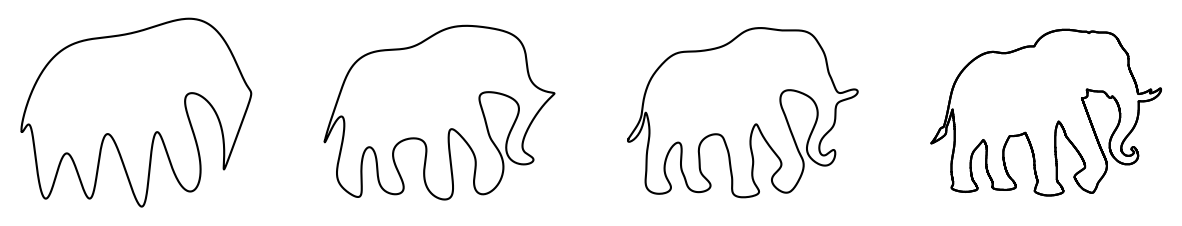

In [45]:
fig,ax = plt.subplots(1,4,figsize=(15,5))

for c,i,j in zip(cc,I_start,J_start):
    x,y = true_contour(c)
    x,y = x+j,y-i
    ax[-1].plot(x,y,'k')
    ax[-1].plot(x,y,'k')
ax[-1].set_aspect(1)
ax[-1].set_axis_off()
#ax[-1].set_title('Exact contours')

#N_fc_outer,N_fc_inner = [[10,1],[20,2],[30,3]] 	# rhino2
N_fc = [[10],[20],[40]]                                    # elephant
for k,n_fc in enumerate(N_fc):
    for n,c,i,j in zip(n_fc,cc,I_start,J_start):
        xf,yf = fourier_contour(c,n,n_eval=1000)
        xf,yf = xf+j,yf-i
        ax[k].plot(xf,yf,'k')
    ax[k].set_aspect(1)
    ax[k].set_axis_off()
#fig.savefig('./result.png')